### Conceitos de Séries Temporais

Em estatística, econometria, matemática aplicada e processamento de sinais, uma série temporal é uma coleção de observações feitas sequencialmente ao longo do tempo. Em séries temporais a ordem dos dados é fundamental. Uma característica muito importante deste tipo de dados é que as observações vizinhas são dependentes e o interesse é analisar e modelar essa dependência. (Wikipédia)

Ao nosso redor existem padrões que se repetem constantemente durante o tempo, pode-se notar padrões repetitivos no clima, com as estações do tempo; no trânsito, com os horários de pico de ida e volta ao trabalho e escola; nas batidas do coração, onde procura-se padrões fora da normalidade; em ações da bolsa de valores, como também em nos ciclos de venda de determinados produtos.

In [1]:
#importando bibliotecas essenciais
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# importando as bibliotecas dos modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import joblib
from sklearn import tree

%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Série Estacionária

Uma série temporal estacionária é aquela cujas propriedades estatísticas, como a média, a variância e a autocorrelação, são constantes ao longo do tempo. Assim, uma série não estacionária é uma cujas propriedades estatísticas mudam com o tempo.

Antes de iniciar qualquer modelagem preditiva é necessário verificar se essas propriedades estatísticas são constantes, abaixo explicarei cada um desses pontos:

* Média constante
* Com variância constante
* Auto correlacionada

#### Leitura do Dataset

In [246]:
#Importando os dados
df = pd.read_csv('DADO4KGPROD.csv')
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y%m%d')
# Totaliza as Quantidades por dia
df = df.groupby('DATA')['QTDE'].sum().reset_index()
df.sort_values('DATA')
df.set_index('DATA', inplace=True)

df.head(5)

,QTDE
DATA,
2020-10-06,133.36
2020-10-07,95.25
2020-10-08,88.31
2020-10-09,51.36
2020-10-10,15.82


### Análise Estatística e Visual dos Dados

In [248]:
df.describe()

,QTDE
count,125.000000
mean,73.637154
std,43.626425
min,15.820000
25%,39.190000
50%,62.670000
75%,102.890000
max,181.940000


#### Histograma

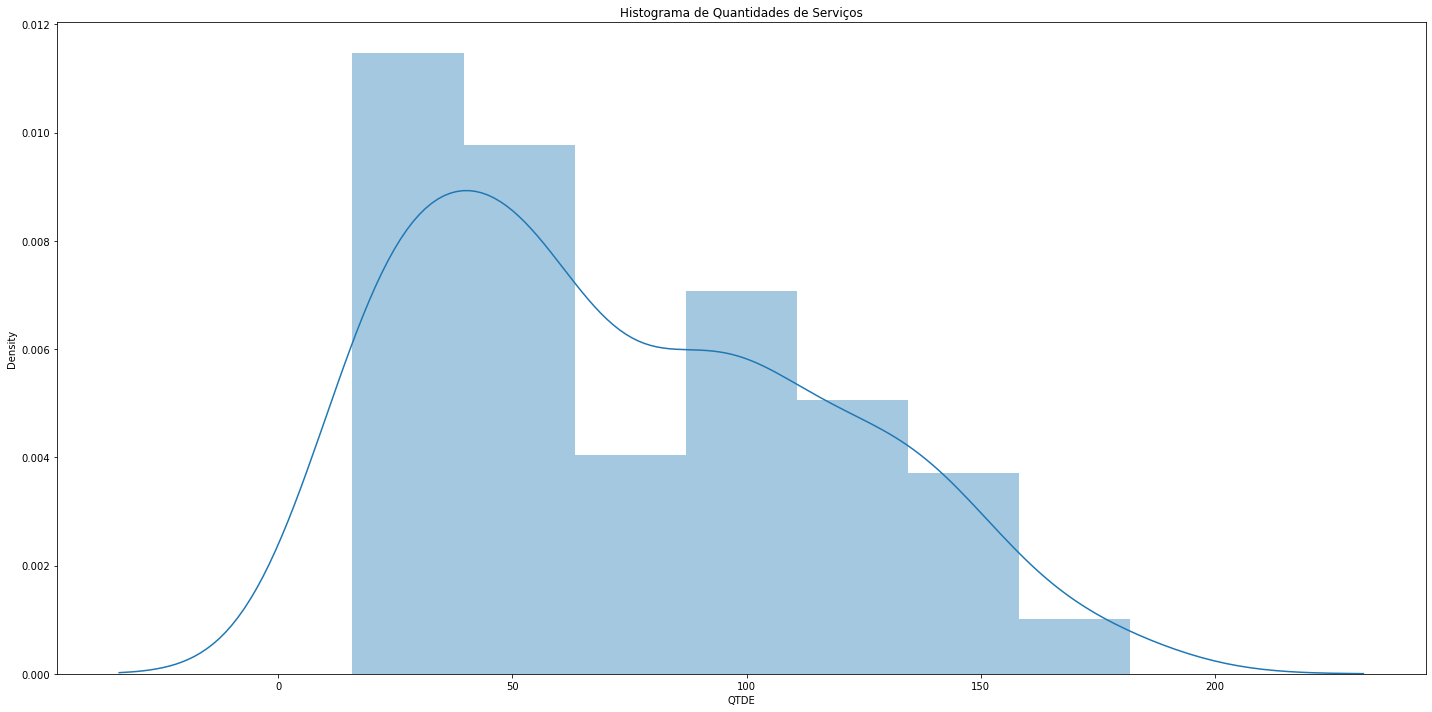

In [107]:
plt.figure(figsize=(20,10))
ax = plt.title('Histograma de Quantidades de Serviços')
sns.distplot(df['QTDE'])
plt.tight_layout();

#### Teste de Normalidade de Kolgomorov-Smirnov 

In [108]:
from scipy.stats import kstest, ks_2samp
ks_test = kstest(df_prov, 'norm', alternative = 'less')
print("Teste de Normalidade de Kolgomorov-Smirnov\n")
print(f'Estatístico: {ks_test[0]}  |  P-value: {ks_test[1]}')

Teste de Normalidade de Kolgomorov-Smirnov

Estatístico: 0.9792846136746434  |  P-value: 0.0


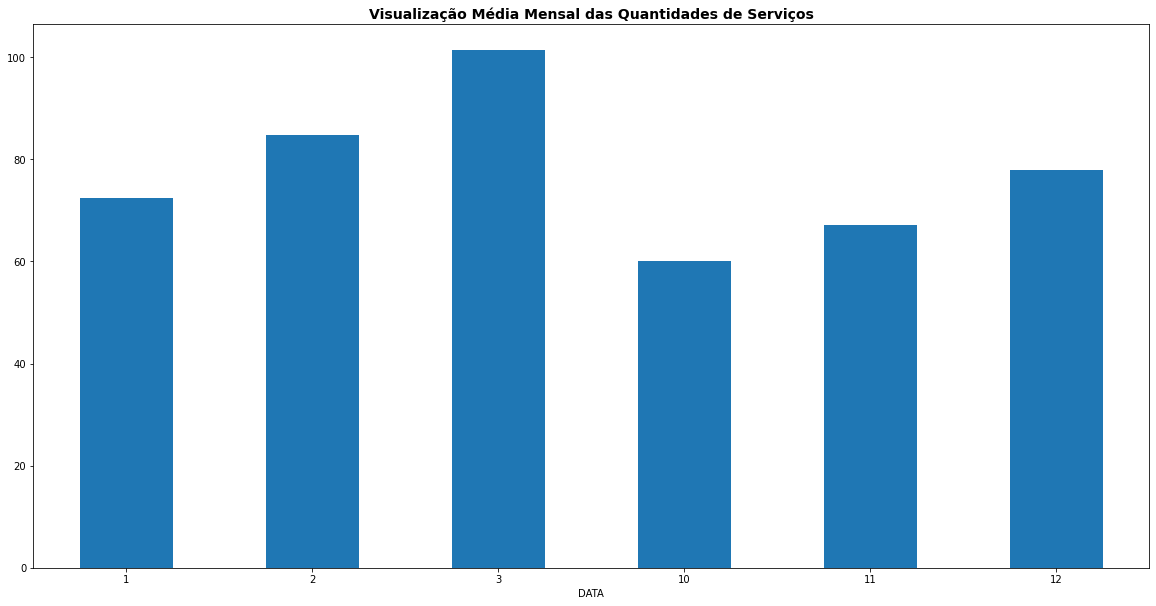

In [109]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Visualização Média Mensal das Quantidades de Serviços', fontsize=14, fontweight='bold')
df.groupby(df.index.month).QTDE.mean().plot.bar(rot=0);

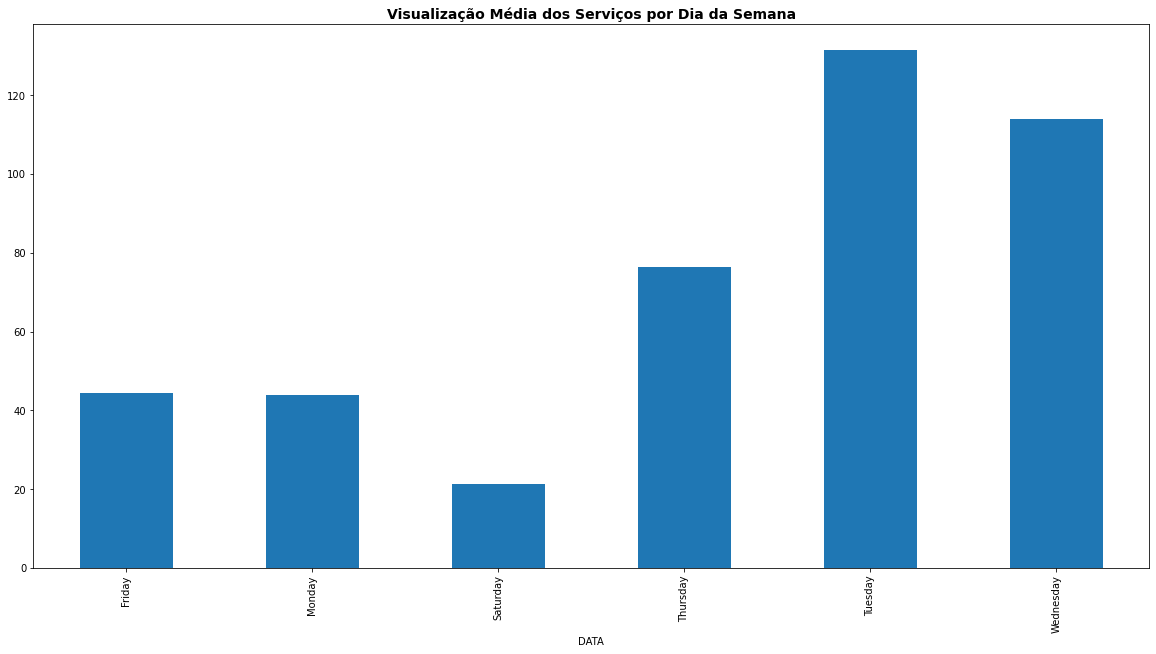

In [110]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.title('Visualização Média dos Serviços por Dia da Semana', fontsize=14, fontweight='bold')
df.groupby(df.index.day_name()).QTDE.mean().plot.bar();

### Dividindo os dados em base de treinamento e de teste

Dados de Teste: 20% da amostra total;

Diferente de outros métodos de previsões, como classificações e regressões sem a influência do tempo, em séries temporais não podemos dividir os dados de treino e teste com amostras aleatórias de qualquer parte dos dados, deve-se seguir o critério temporal da série, onde os dados de treino devem vir antes dos dados de teste. 

In [111]:
dias = int(df.shape[0] * 0.2) # 20% do Dataset
treino = df.iloc[:-dias,0:7].copy()
teste = df.iloc[-dias:,0:7].copy()

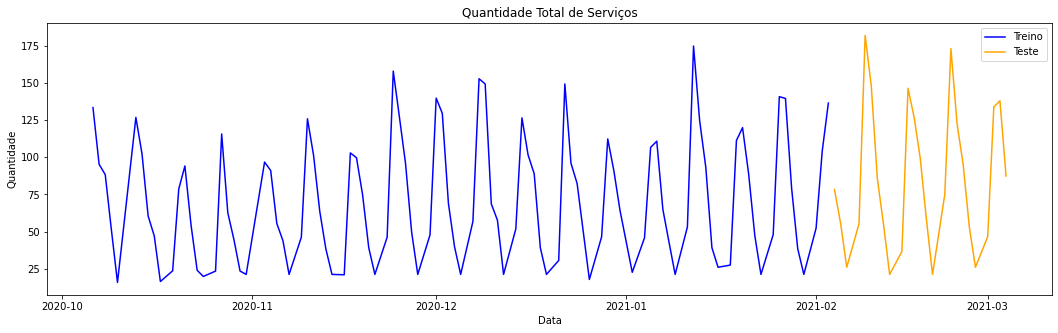

In [112]:
plt.figure(figsize=(18,5))
plt.title('Quantidade Total de Serviços')
plt.plot(treino['QTDE'], color='b')
plt.plot(teste['QTDE'], color='orange')
plt.legend(['Treino','Teste'])
# plt.yticks(np.arange(0, 1000, step=50))
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.show()

### Série Estacionária
#### Média Constante

Uma série estacionária tem média constante durante o tempo, não existe tendências de alta ou de baixa. A razão disso é que tendo uma média constante com variações ao redor desta média fica muito mais fácil de realizar previsões.

Há casos que a variância é pequena em relação à média e usá-la pode ser uma boa métrica para fazer previsões, abaixo um gráfico para mostrar a média em relação as variações ao longo do tempo:

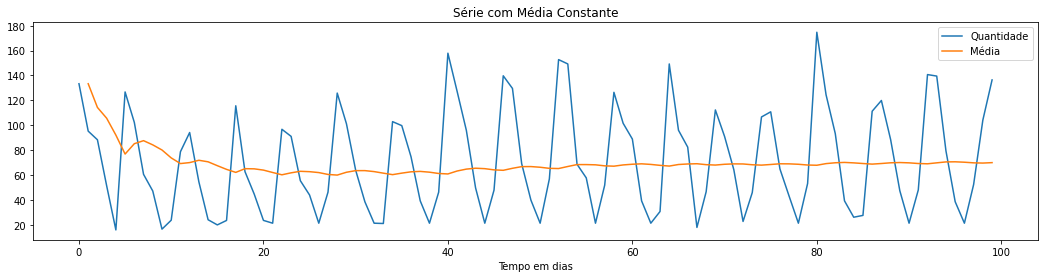

In [113]:
quantidade = treino['QTDE'].to_numpy()

#Criando uma média que se expande da primeira quantidade e acumulado até cada dia anterior
mean = [np.mean(quantidade[:x]) for x in range(len(quantidade))]
plt.figure(figsize=(18,4))
plt.plot(quantidade, label='Quantidade')
plt.plot(mean, label='Média')
plt.title('Série com Média Constante')
plt.xlabel('Tempo em dias')
plt.legend()
plt.show()

#### Teste de Dickey Fuller
Testes estatísticos para confirmar se a séries é estacionária. Vamos usar dois testes: o teste de [Dickey Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) e o teste [KPSS](https://en.wikipedia.org/wiki/KPSS_test).

Primeiramente vamos usar o teste de Dickey Fuller, usarei o [valor P](https://pt.wikipedia.org/wiki/Valor-p) base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária. 

Além disso, existe o **Teste estatístico** do modelo, onde estes valores podem ser comparados com os **valores críticos** de 1%, 5% e 10%, caso o teste estatístico esteja abaixo de algum valor critico escolhido a série será estacionária:

In [114]:
#Teste de Dickey Fuller
adfinput = adfuller(treino['QTDE'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
adftest

Teste Estatistico Dickey Fuller    -2.4368
Valor-P                             0.1316
Lags Usados                         5.0000
Número de observações usadas       94.0000
Valores Críticos (1%)              -3.5019
Valores Críticos (5%)              -2.8928
Valores Críticos (10%)             -2.5835
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série é estacionária (Valor P de 0.0% e o valor crítico de 5% é menor que o teste estatístico)

#### Teste KPSS
O teste KPSS, ao contrário do teste de Dickey Fuller, já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5% ou o teste estatístico for menor que algum valor crítico escolhido:

In [115]:
kpss_input = kpss(treino['QTDE'])
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       0.2841
Valor-P                     0.1000
Lags Usados                12.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

#### A Decomposição da Série
Toda série temporal pode ser decomposta em 3 partes: **tendência**, **sazonalidade** e **resíduo**, que é o que resta após retirar da série as duas primeiras partes, abaixo a separação dessas partes:

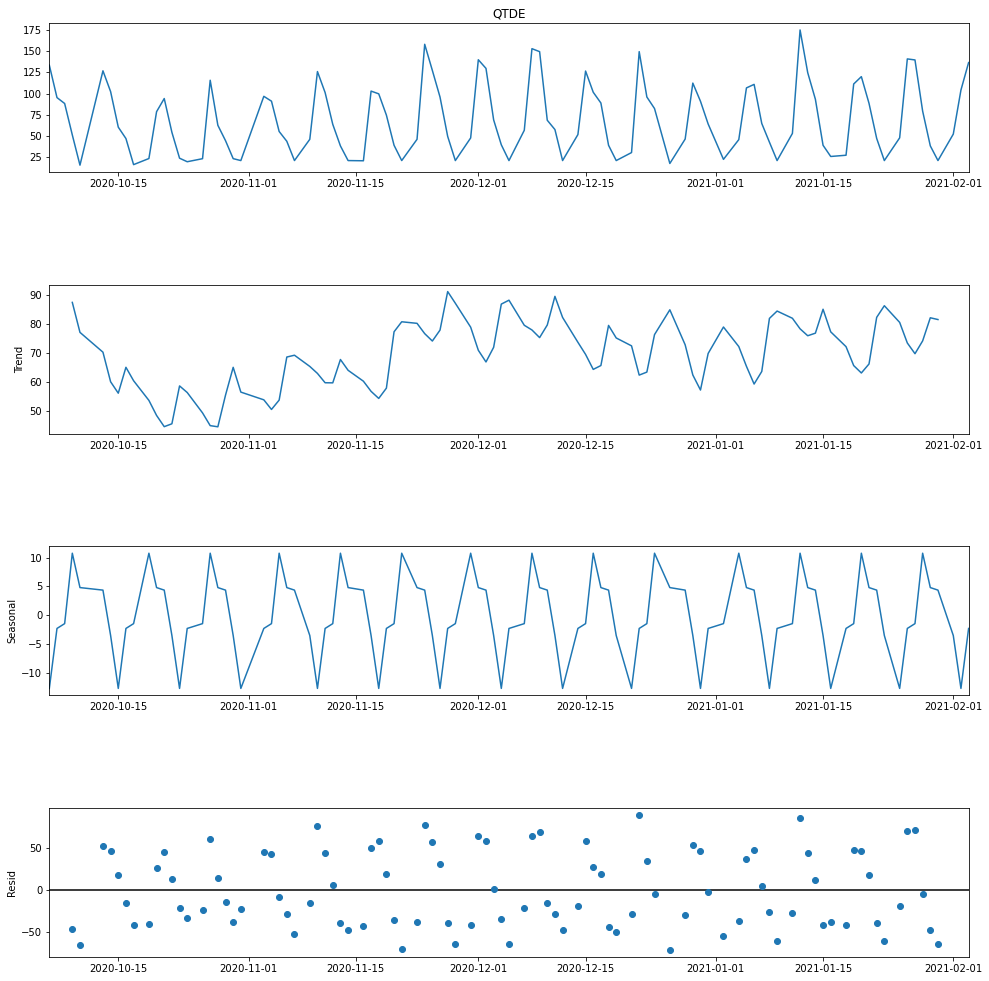

In [119]:
#gráfico diário com ciclos que se repetem a cada 30 dias (1 mês)
season = seasonal_decompose(treino['QTDE'], freq=7)
fig = season.plot();
fig.set_size_inches(16,16)

**Análise:** Não foi possível identificar uma tendência para a série no período analisado. A sazonalidade se mostra em ciclos semanais constantes e observa que há muitos resíduos que se apresentam em ciclos semanais, sugerindo os picos "aleátórios" de serviços.

## Lags Correlacionados

Para ter previsibilidade uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (**lag**).

Como esta série de quantidade de serviços têm períodos semanais, 1 ano tem 52 semanas, irei usar a função de auto correlação para um período de 52 lags para verificar correlações do período atual com estes lags.

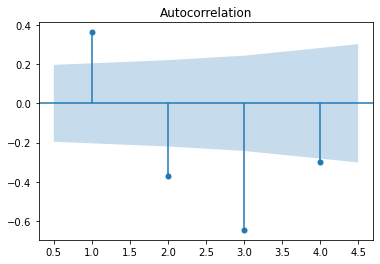

In [131]:
plot_acf(treino['QTDE'], lags=4, zero=False);

**Conclusão:** Ao analisar o gráfico de auto correlação gerado acima, verifica-se que os primeiros lags poderiam ser usados para criar previsões para eventos futuros, pois têm uma correlação positiva e estão fora do intervalo de confiança (área azul), ainda que indiquem correlação baixa (Não próximo a 1).

Uma outra função extremamente importante é a função de **auto correlação parcial**, onde o efeito do lag anterior sobre o período atual é removido e só resta o efeito do lag analisado sobre o período atual, exemplo: a auto correlação parcial do quarto lag irá remover o efeito do primeiro, segundo e terceiro lag.

Abaixo o gráfico de auto correlação parcial:

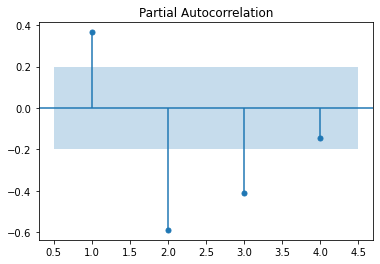

In [132]:
plot_pacf(treino['QTDE'], lags=4, zero=False);

Observa-se que 2 lags têm efeito sobre o período atual. Usaremos somente os dois primeiros lags como fator de previsão para séries auto regressivas.

## Métricas para avaliar o modelo

Para analisar se as previsões estão com os valores próximos dos dados reais deve-se fazer a medição do erro, o erro (ou **resíduo**) neste caso é basicamente $Y_{REAL} - Y_{PREVISÃO}$.

Avalia-se o erro nos dados de treino para verificar se o modelo tem boa assertividade, e valida-se o modelo verificando o erro nos dados de teste (dados que não foram "vistos" pelo modelo).

Abaixo estão as principais métricas usadas para avaliar modelos de séries temporais:

### MEAN FORECAST ERROR -  (ERRO MÉDIO DA PREVISÃO ou VIÉS)

O erro médio da previsão nada mais é do que a média dos erros da série avaliada, os valores podem ser positivos ou negativos. Essa métrica sugere que o modelo tende a fazer previsões acima do real (erros negativos) ou abaixo do real (erros positivos), desse modo também pode-se dizer que o **erro médio** é o viés do modelo.

### MAE - MEAN ABSOLUTE ERROR - (ERRO MÉDIO ABSOLUTO)

Essa métrica é muito semelhante ao erro médio da previsão mencionado acima, a única diferença é o erro com valor negativo, ou seja, a previsão com valor maior que o número real, é transformado em positivo e posteriormente a média é calculada. 

Essa métrica é muito usada em séries temporais, pois há casos que o erro negativo pode zerar o positivo ou dar uma ideia que o modelo é preciso, no caso do MAE isso não acontece, pois essa métrica mostra o quanto a previsão está longe dos valores reais, independente se acima ou abaixo, veja o caso abaixo:

In [17]:
a = np.array([1,2,3,4,5])
b = np.array([5,4,3,2,1])

erro = a - b

MFE = erro.mean()
MAE = np.abs(erro).mean()
print(f'O erro de cada valor do modelo ficou assim: {erro}')
print(f'O cálculo do erro da MFE é {MFE}, o erro da MAE é {MAE}')

O erro de cada valor do modelo ficou assim: [-4 -2  0  2  4]
O cálculo do erro da MFE é 0.0, o erro da MAE é 2.4


### MSE - MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO)

Essa métrica coloca mais peso nos erros maiores, pois cada valor individual do erro é elevado ao quadrado e posteriormente a média desses valores é calculada. Assim, essa métrica é muito sensível à *outliers* e coloca bastante peso nas previsões com erros mais significativos.

Diferente do MAE e MFE, os valores do MSE estão em unidades quadráticas e não na unidade do modelo.

### RMSE - ROOT MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO DA RAIZ)

Essa métrica é simplesmente a raiz quadrada do MSE, onde o erro volta a ter a unidade de medida do modelo (R$/m3), ela é muito usada em séries temporais porque é mais sensível à erros maiores devido ao processo de elevação ao quadrado que a originou.

### MAPE - MEAN ABSOLUTE PERCENTAGE ERROR - (ERRO PERCENTUAL MÉDIO ABSOLUTO)

Essa é outra métrica interessante de ser usada, geralmente usada em relatórios gerenciais, pois o erro é medido em termos percentuais e pode-se comparar o erro percentual do modelo de um produto X com o erro percentual de um produto Y.

O cálculo dessa métrica pega o valor absoluto do erro dividido pelo preço real e posteriormente é calculada a média:

${\displaystyle {\mbox{MAPE}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {Y_{REAL}-Y_{PREVISTO}}{Y_{REAL}}}\right|,}$

Vamos criar uma função para avaliar o erro dos dados de treino e teste com várias métricas de avaliação:

In [124]:
#Bibliotecas para criar a função:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

# Checando os valores residuais

Criar o modelo e verificar o valor do seu resíduo de acordo com a métrica escolhida não é suficiente, é necessário analisar também o próprio resíduo, pois há casos em que o modelo não consegue capturar as informações necessárias para se fazer uma boa previsão resultando em um resíduo com "informações na mesa".

Para verificar este resíduo iremos checar:

* **Valores reais vs previstos (sequencial);**
* **Resíduo vs valores previstos (dispersão):**
    * É muito importante analisar este gráfico, pois nele podemos verificar padrões que podem nos dizer se é necessária alguma modificação no modelo, o ideal é que o erro esteja distribuído linearmente ao longo da sequência da previsão.
* **[QQ plot](https://pt.wikipedia.org/wiki/Gr%C3%A1fico_Q-Q) do resíduo (dispersão):**
    * Resumindo esse é um gráfico que mostra onde o resíduo deveria estar distribuído teoricamente, seguindo uma distribuição gaussiana, contra como ele realmente ficou.
* **Autocorrelação do resíduo (sequencial):**
    * Onde não deve haver valores que saiam da margem de confiança, ou o modelo está deixando informação na mesa.
   
Para isso precisamos criar outra função para plotar estes gráficos:

In [133]:
def plotar_erro(dados, figsize=(18,8)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=4,zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

### Modelos Básicos de Previsão

Passos que iremos seguir para cada modelo:

* Criar previsão nas base de treino posteriormente validar na base de teste;
* Checar o erro de cada modelo de acordo com as métricas mencionadas acima;
* Plotar o modelo com os comparativos do resíduo.

#### Abordagem Simples: 

Para fazer a previsão de um período, usaremos o valor do período anterior. Porém usar essa metodologia para prever vários períodos adiante geralmente não funciona bem, pois os erros em relação ao valores reais tendem a aumentar.

Este modelo será usado como **_baseline_** para tentar melhorar com modelos mais complexos.

In [217]:
simples_treino = treino[['QTDE']]
simples_treino.columns = ['Real']
simples_treino['Previsão'] = simples_treino['Real'].shift()
simples_treino.dropna(inplace=True)

MODELO SIMPLES NA BASE DE TREINO


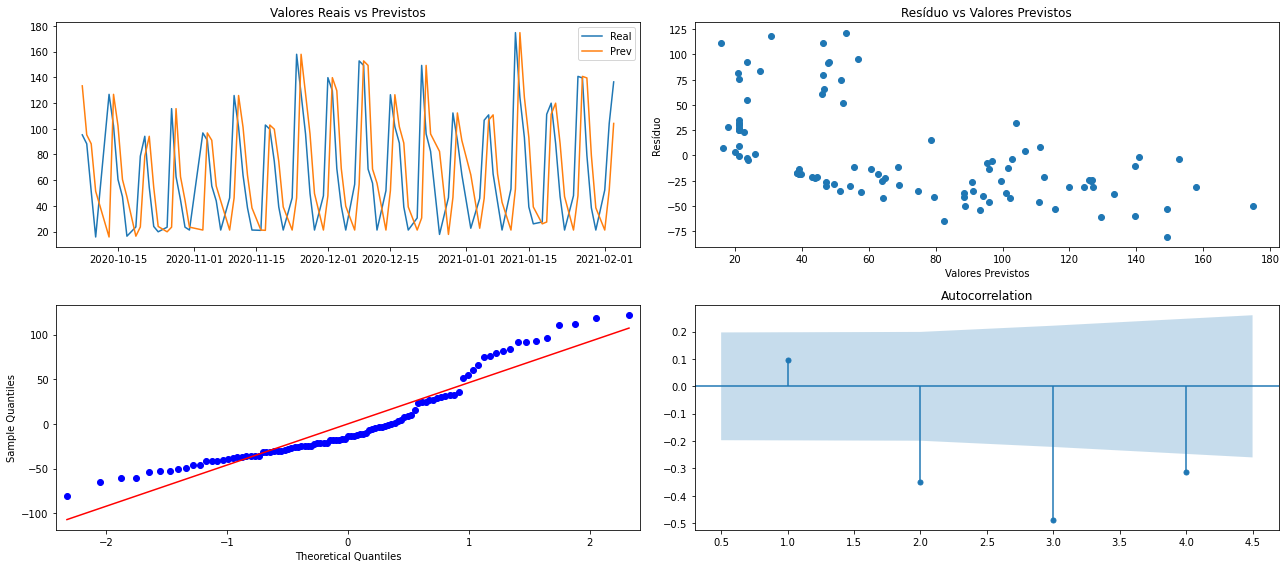

,Simples
Base Treino,
VIÉS,0.031010
MSE,2163.127443
RMSE,46.509434
MAE,36.965337
MAPE,64.688574


In [136]:
#Criando variável de treino para comparar o erro posteriormente e apresenta gráficos da abordagem
erro_treino = check_erro(simples_treino['Real'], 
                         simples_treino['Previsão'], 
                         nome_col='Simples', 
                         nome_indice='Base Treino')

print('MODELO SIMPLES NA BASE DE TREINO')
plotar_erro(simples_treino)
erro_treino

O gráfico QQ mostra que há alguns resíduos maiores (para cima e para baixo) do que teoricamente deveriam haver que são os chamados outliers, e ainda existe uma autocorrelação negativa significativa no primeiro lag, o qual poderá ser usado para melhorar o modelo.

MODELO SIMPLES NA BASE DE TESTE


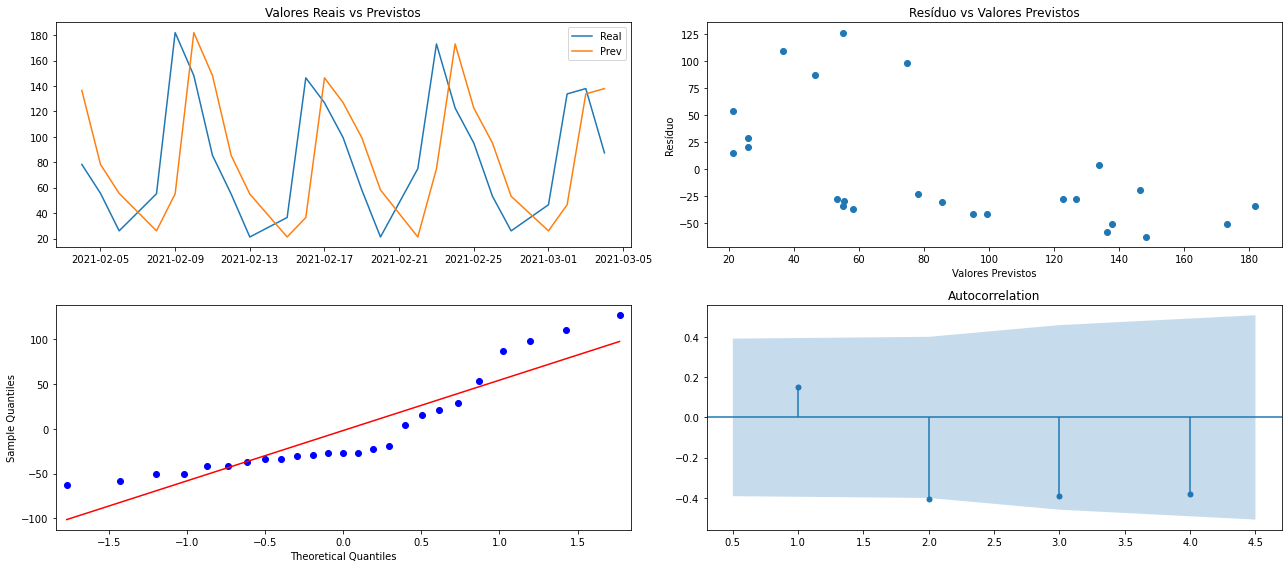

,Simples
Base Teste,
VIÉS,-1.962000
MSE,2968.465150
RMSE,54.483623
MAE,45.545200
MAPE,64.746020


In [137]:
simples_teste = teste[['QTDE']]
simples_teste.columns = ['Real']

#adicionando o primeiro valor da Previsão com o último dado Real do teste
hist = [simples_treino.iloc[i,0] for i in range(len(simples_treino))]
prev = []
for t in range(len(simples_teste)):
    yhat = hist[-1]
    obs = simples_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)

simples_teste['Previsão'] = prev

#criando a base de erro no teste
erro_teste = check_erro(simples_teste['Real'], 
                        simples_teste['Previsão'], 
                        nome_col='Simples',
                       nome_indice='Base Teste')

print('MODELO SIMPLES NA BASE DE TESTE')
plotar_erro(simples_teste)
erro_teste

Todas as métricas ficam melhores nos dados de teste, o gráfico QQ segue semelhante nas duas bases de dados.

No gráfico que compara os resíduos com os valores previstos nota-se que há uma tendência de os erros aumentarem em valores absolutos quando os serviços aumentam, talvez um ajuste com logaritmos diminuísse essa expansão dos erros, e para finalizar o gráfico de auto correlação mostra que ainda há espaço para melhoras, pois há uma correlação forte no primeiro lag, onde provavelmente poderia ser adicionada uma regressão com base no primeiro lag para melhorar as previsões.

#### Média Simples:

Este modelo usa a média do início dos dados até a data anterior e vai expandindo diariamente até o final dos dados.

In [138]:
ms_treino = treino[['QTDE']]
ms_treino.columns = ['Real']
ms_treino['Previsão'] = ms_treino['Real'].expanding().mean()

#Verificando o erro do modelo de média simples
erro_treino['Média Simples'] = check_erro(ms_treino['Real'], ms_treino['Previsão'])
erro_treino.round(4)

,Simples,Média Simples
Base Treino,,
VIÉS,0.0310,1.3249
MSE,2163.1274,1678.7301
RMSE,46.5094,40.9723
MAE,36.9653,34.8448
MAPE,64.6886,78.1601


MODELO DE MÉDIA SIMPLES NA BASE DE TESTE


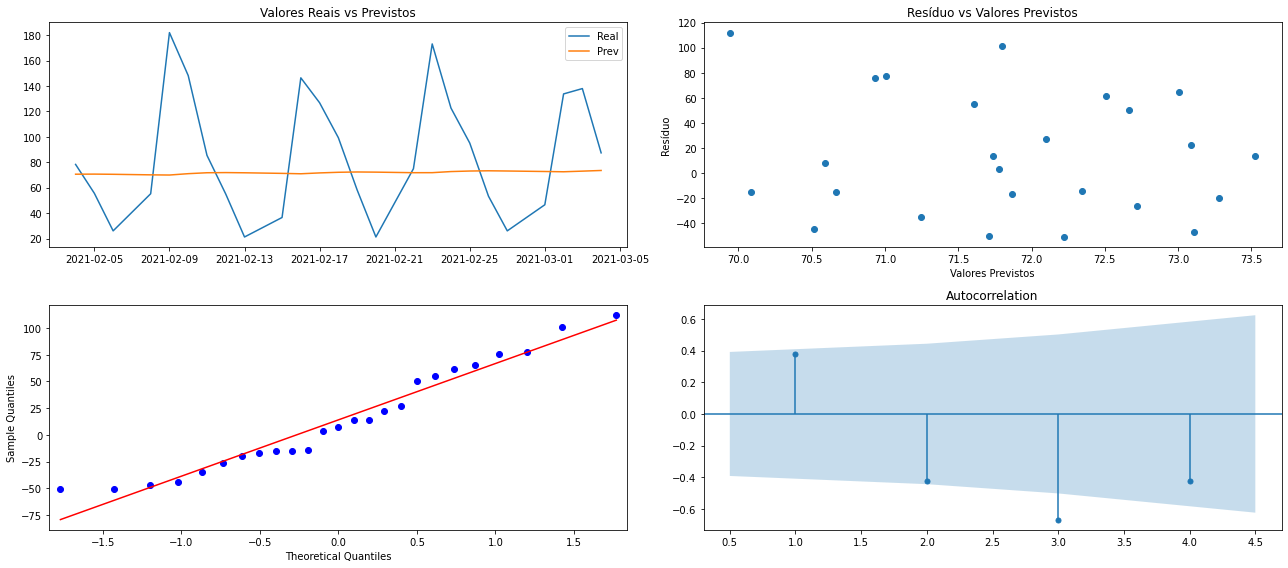

,Simples,Média Simples
Base Teste,,
VIÉS,-1.962000,13.990283
MSE,2968.465150,2487.143355
RMSE,54.483623,49.871268
MAE,45.545200,40.781913
MAPE,64.746020,64.999054


In [139]:
# Dados de Teste
ms_teste = teste[['QTDE']]
ms_teste.columns = ['Real']

# Continuando a usar a média para a série de testes
hist = [ms_treino.iloc[i,0] for i in range(len(ms_treino))]
prev = []
for t in range(len(ms_teste)):
    yhat = np.mean(hist)
    obs = ms_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)

ms_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO DE MÉDIA SIMPLES NA BASE DE TESTE')
plotar_erro(ms_teste)

#Adicionando o erro da média simples no teste:
erro_teste['Média Simples'] = check_erro(ms_teste['Real'], ms_teste['Previsão'])
erro_teste

O modelo de média simples não conseguiu capturar informações relevantes da série de quantidade de serviços, como pode ser visto no gráfico de Real vs Previsto como também nos gráficos de auto correlação e Resíduos vs Previsto. Porém, os indicadores não foram muito ruins.

#### Média Móvel Simples:

A média móvel é uma média que é calculada por um período determinado (2 dias por exemplo) e vai se movendo e sendo calculada sempre usando este período determinado, neste caso estaremos usando sempre a média dos últimos 2 dias para prever o valor do dia seguinte.

In [186]:
mm_treino = treino[['QTDE']]
mm_treino.columns = ['Real']
mm_treino['Previsão'] = mm_treino.rolling(2).mean()
mm_treino.dropna(inplace=True)

# Checando o erro do modelo de treino de médias móveis
erro_treino['Média Móvel 2D'] = check_erro(mm_treino['Real'], mm_treino['Previsão'])
erro_treino.round(4)

,Simples,Média Simples,Média Móvel 2D,Auto Regr.
Base Treino,,,,
VIÉS,0.0310,1.3249,0.0155,85.3269
MSE,2163.1274,1678.7301,540.7819,8357.7627
RMSE,46.5094,40.9723,23.2547,91.4208
MAE,36.9653,34.8448,18.4827,85.3269
MAPE,64.6886,78.1601,32.3443,120.2681


Nas bases de treino, este modelo teve o melhor desempenho até aqui.

MODELO DE MÉDIA MÓVEL DE 2 DIAS NA BASE DE TESTE


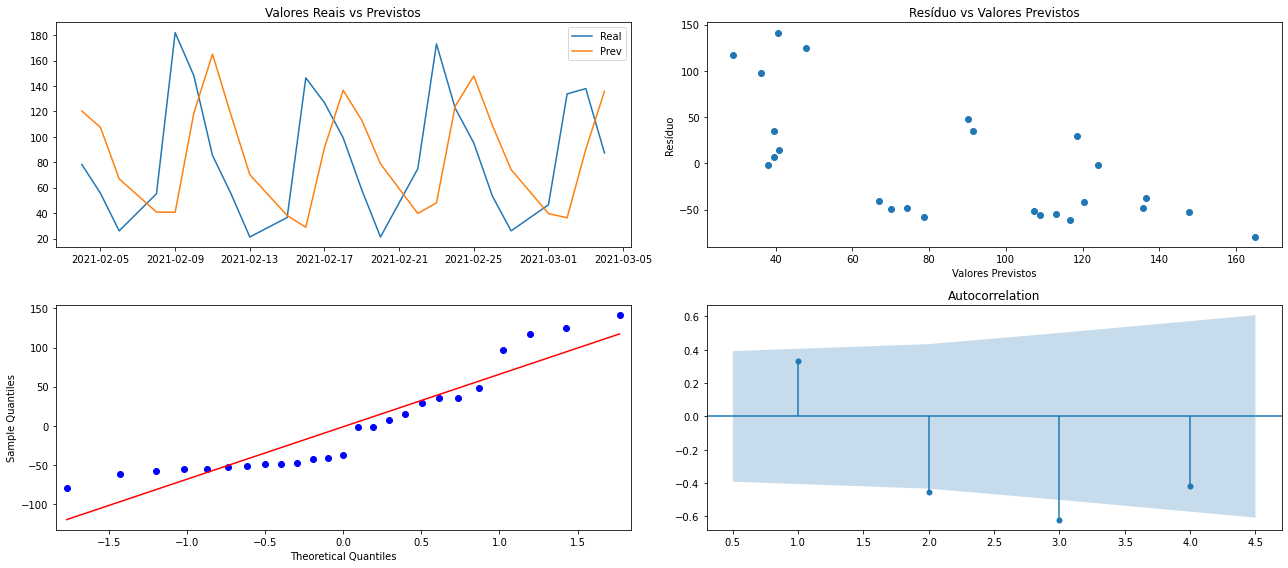

,Simples,Média Simples,Média Móvel 2D
Base Teste,,,
VIÉS,-1.962000,13.990283,-1.286000
MSE,2968.465150,2487.143355,4068.462592
RMSE,54.483623,49.871268,63.784501
MAE,45.545200,40.781913,53.321400
MAPE,64.746020,64.999054,80.893420


In [141]:
mm_teste = teste[['QTDE']]
mm_teste.columns = ['Real']

# Continuando a usar a média móvel de 2 dias passo a passo:
hist = [mm_treino.iloc[i,0] for i in range(len(mm_treino))]
prev = []
for t in range(len(mm_teste)):
    yhat = np.mean(hist[-2:])
    obs = mm_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    
mm_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO DE MÉDIA MÓVEL DE 2 DIAS NA BASE DE TESTE')
plotar_erro(mm_teste)

# Checando o erro do modelo de teste de médias móveis
erro_teste['Média Móvel 2D'] = check_erro(mm_teste['Real'], mm_teste['Previsão'])
erro_teste

Do mesmo modo que o treino, o modelo de médias móveis estão melhores do que a média simples, porém ainda não ganham do modelo simples.

As previsões estão com auto correlação em alguns lags e o erro está com uma variância muito alta em relação aos valores previstos.

#### Auto Regressivo:

Um modelo auto regressivo é basicamente uma regressão linear com lags significativamente correlacionados, onde inicialmente deve-se plotar o gráfico de autocorrelação e autocorrelação parcial para verificar se existe algo relevante, havendo, treina-se o modelo com estes lags.

Abaixo está o gráfico de autocorrelação e autocorrelação parcial da série de treino que mostra uma assinatura de modelo auto regressivo 2 lags com correlações significativas:

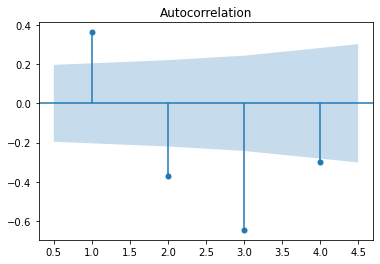

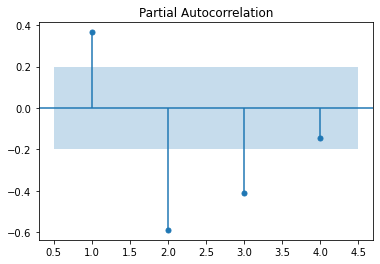

In [142]:
plot_acf(treino['QTDE'], lags=4, zero=False);
plot_pacf(treino['QTDE'], lags=4, zero=False);

In [143]:
ar_treino = treino[['QTDE']]
ar_treino.columns = ['Real']

#criando o modelo:
from statsmodels.tsa.arima_model import ARMA
modelo = ARMA(ar_treino['Real'], order=[2,0]).fit()
ar_treino['Previsão'] = modelo.predict(start=0, end=len(ar_treino)-1)

# Checando o erro do modelo auto regressivo
erro_treino['Auto Regr.'] = check_erro(ar_treino['Real'], ar_treino['Previsão'])
erro_treino

,Simples,Média Simples,Média Móvel 2D,Auto Regr.
Base Treino,,,,
VIÉS,0.031010,1.324928,0.015505,0.289937
MSE,2163.127443,1678.730149,540.781861,994.609504
RMSE,46.509434,40.972310,23.254717,31.537430
MAE,36.965337,34.844825,18.482669,24.812807
MAPE,64.688574,78.160127,32.344287,55.090930


MODELO AUTO REGRESSIVO NA BASE DE TESTE


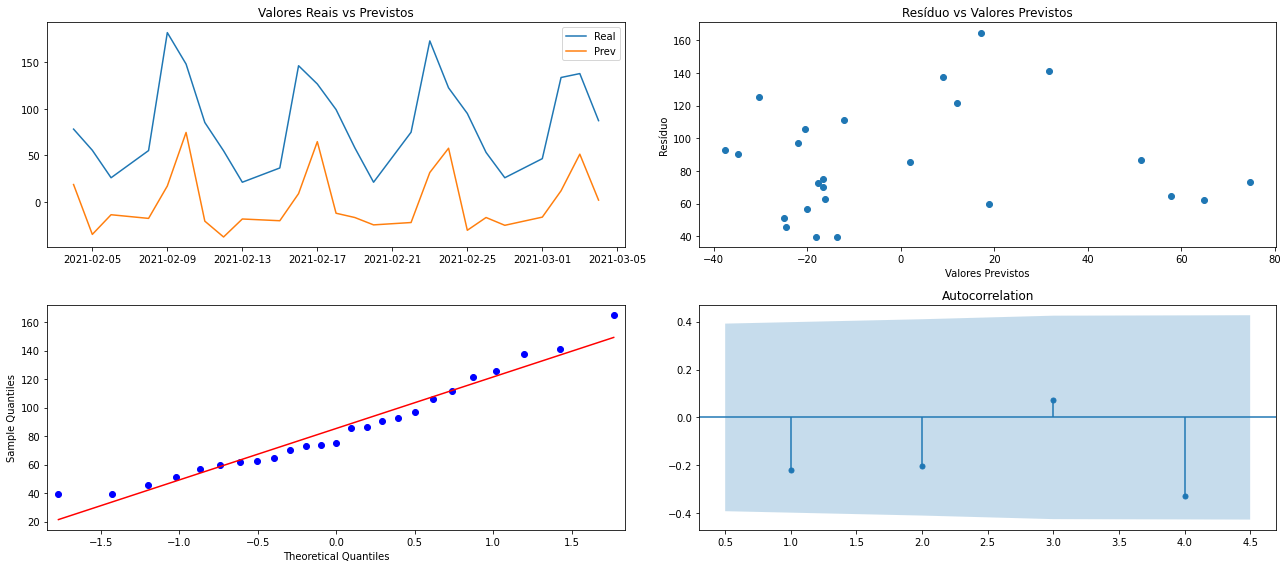

,Simples,Média Simples,Média Móvel 2D,Auto Regr.
Base Treino,,,,
VIÉS,0.031010,1.324928,0.015505,85.326879
MSE,2163.127443,1678.730149,540.781861,8357.762675
RMSE,46.509434,40.972310,23.254717,91.420800
MAE,36.965337,34.844825,18.482669,85.326879
MAPE,64.688574,78.160127,32.344287,120.268079


In [144]:
ar_teste = teste[['QTDE']]
ar_teste.columns = ['Real']

#validando os dados usando os coeficientes do modelo treinado:
coef_l1, coef_l2 = modelo.arparams
hist = [ar_treino.iloc[i,0] for i in range(len(ar_treino))]
prev = []
for t in range(len(ar_teste)):
    yhat = (hist[-1] * coef_l1) + (hist[-2] * coef_l2)
    obs = ar_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    
ar_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO AUTO REGRESSIVO NA BASE DE TESTE')
plotar_erro(ar_teste)

# Checando o erro do modelo auto regressivo
erro_treino['Auto Regr.'] = check_erro(ar_teste['Real'], ar_teste['Previsão'])
erro_treino

Os valores obtidos com este modelo não foram melhores que os já existentes.

In [234]:
# Concatena treino e teste para usar com features nos algoritmos de ML
df_simples = pd.concat([simples_treino, simples_teste])
df_simples.drop('Real', axis='columns', inplace=True)
df_simples.drop('Erro', axis='columns', inplace=True)

#Média Simples
df_ms = pd.concat([ms_treino, ms_teste])
df_ms.drop('Real', axis='columns', inplace=True)
df_ms.drop('Erro', axis='columns', inplace=True)

#Média Móvel (2D)
df_mm = pd.concat([mm_treino, mm_teste])
df_mm.drop('Real', axis='columns', inplace=True)
df_mm.drop('Erro', axis='columns', inplace=True)

#Auto Regressão
df_ar = pd.concat([ar_treino, ar_teste])
df_ar.drop('Real', axis='columns', inplace=True)
df_ar.drop('Erro', axis='columns', inplace=True)

### Modelos de Machine Learning

In [235]:
df['Simples'] = df_simples['Previsão']
df['Media Simples'] = df_ms['Previsão']
df['Media Movel'] = df_mm['Previsão']
df['Auto Reg'] = df_ar['Previsão']
df.dropna(inplace=True)
df

,QTDE,Simples,Media Simples,Media Movel,Auto Reg
DATA,,,,,
2020-10-07,95.25,133.36,114.305000,114.305,93.634975
2020-10-08,88.31,95.25,105.640000,91.780,47.495155
2020-10-09,51.36,88.31,92.070000,69.835,66.048077
2020-10-10,15.82,51.36,76.820000,33.590,48.334297
2020-10-13,126.76,15.82,85.143333,71.290,49.293599
...,...,...,...,...,...
2021-02-27,26.03,53.25,73.108452,74.175,-25.059557
2021-03-01,46.56,26.03,72.719374,39.640,-16.269867
2021-03-02,133.73,46.56,72.504952,36.295,12.045564


In [236]:
# Função para Cross Validation para Séries Temporais

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [237]:
# 5 folds Cross-validation para séries temporais 
tscv = TimeSeriesSplit(n_splits=5)

In [238]:
# Executa train-test split para séries temporais
def timeseries_train_test_split(X, y, test_size):

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [239]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = df.dropna().QTDE
X = df.dropna().drop(['QTDE'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [240]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((99, 4), (25, 4), (99,), (25,))

In [241]:
# Function for mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [242]:

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(20, 10))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    mae = mean_absolute_error(prediction, y_test)
    mse = mean_squared_error(prediction, y_test)
    rmse = mean_squared_error(prediction, y_test, squared=False)
    
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('MAPE:', error)
    print('---------')
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [243]:
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', -np.mean(np.abs((labels - preds) / (labels+1))))

In [244]:
# Cria pipelines
pipe_dt = Pipeline([('clf', tree.DecisionTreeRegressor(max_depth = 5,
                                                       min_samples_split = 5,
                                                       min_samples_leaf = 5))])

pipe_knn = Pipeline([('clf', sk.neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])

pipe_rf = Pipeline([('clf', sk.ensemble.RandomForestRegressor(n_jobs=-1,
                                                              n_estimators = 1000,
                                                              max_depth = 5,
                                                              min_samples_split = 5,
                                                              min_samples_leaf = 5))])

# List of pipelines for ease of iteration
pipelines = [pipe_dt, pipe_knn, pipe_rf]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Decision Tree', 1: 'KNN', 2: 'Random Forest'}

MSE: 0.23430558609166696
RMSE: 0.4840512225908194
MAE: 0.2616934293855911
MAPE: 6.254486294428554
---------
MSE: 0.27613760290556905
RMSE: 0.5254879664707547
MAE: 0.3025230024213076
MAPE: 6.919092974684041
---------
MSE: 0.19557843477749054
RMSE: 0.442242506751093
MAE: 0.23729442153114316
MAPE: 5.524088441639612
---------
Decision Tree pipeline test accuracy: 0.488
KNN pipeline test accuracy: 0.397
Random Forest pipeline test accuracy: 0.573


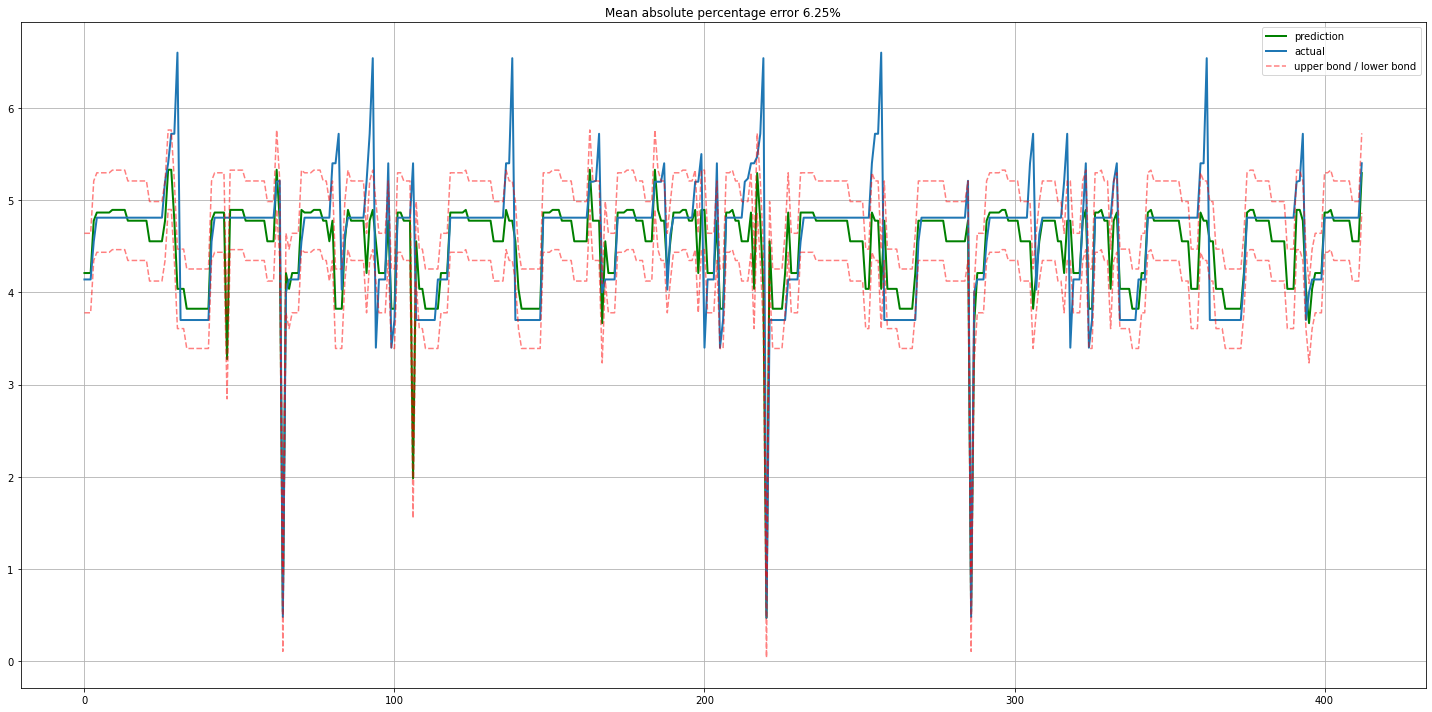

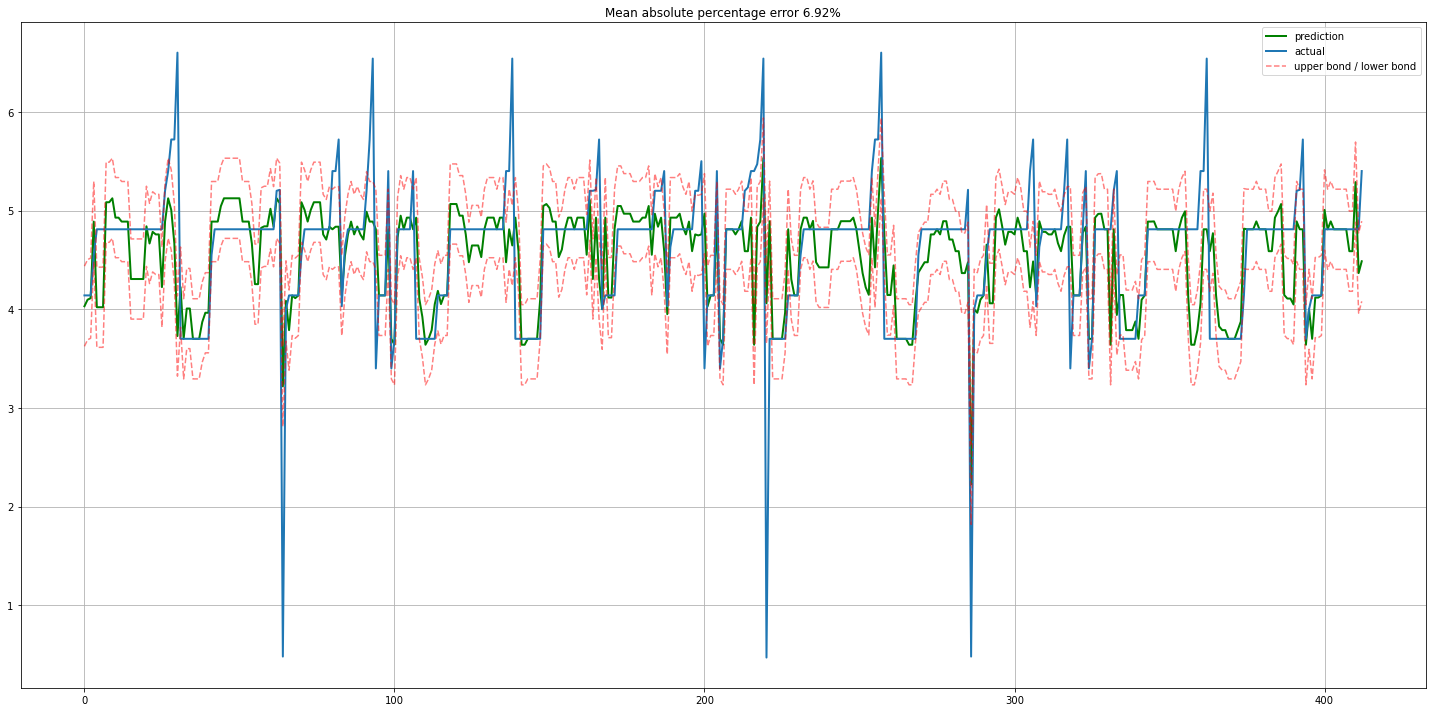

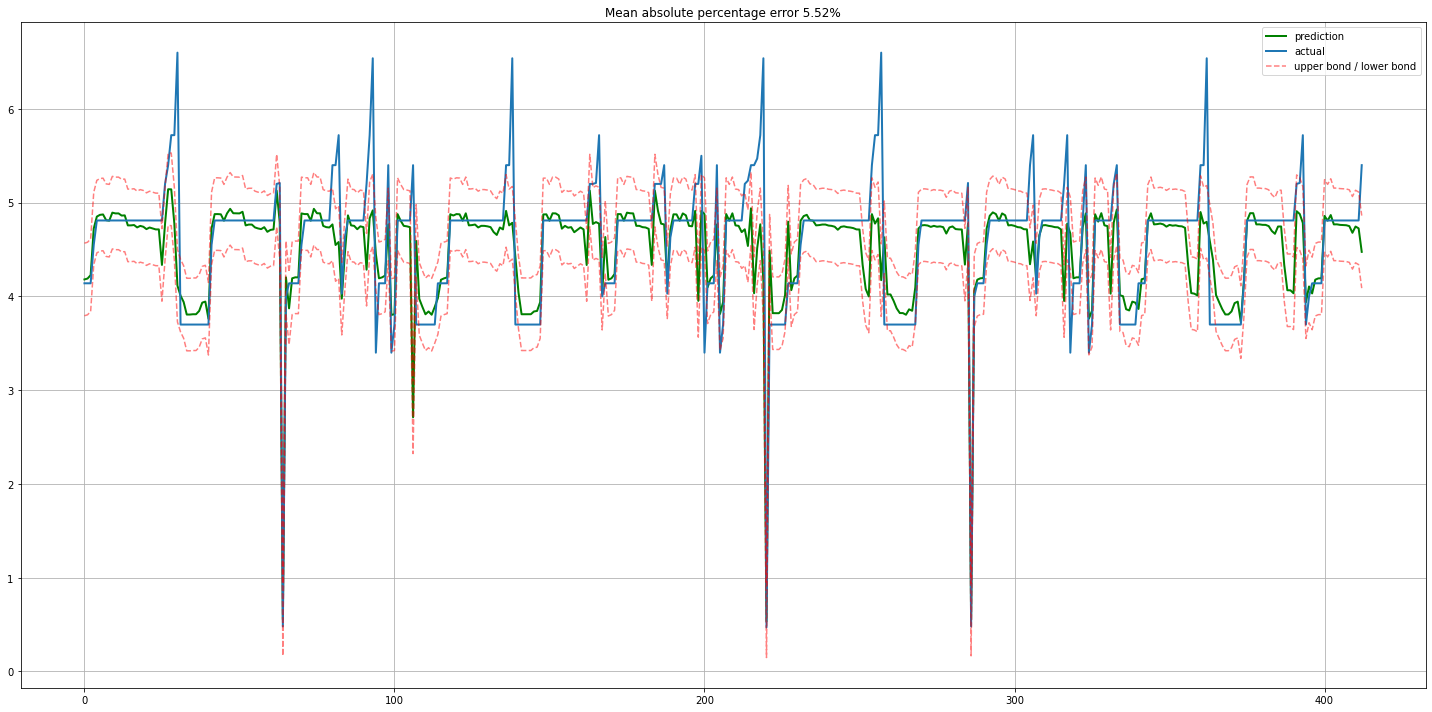

In [40]:
# Fit pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    plotModelResults(pipe, plot_intervals=True, plot_anomalies=False)
    #plotCoefficients(pipe)

# Compara acurácias
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

### Conclusão

Tomando como referência o modelo de Médias Móveis para 2 dias, que obteve o melhor desempenho entre os modelos convencionais, (MAPE 13.87%), a abordagem de Machine Learning foi muito superior, com o melhor desempenho alcançado pelo modelo usando o Random Forest que obteve MAPE de 5,55%.